In [104]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix , precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
image_folder = "D:/Project ML/Training"

data = []
labels = []
fruit_classes = {"Apple": 0, 
                 "Banana": 1, 
                 "EggPlant": 2, 
                 "Orange": 3, 
                 "Pepper": 4
                 }
for fruit, label in fruit_classes.items():
    fruit_folder = os.path.join(image_folder, fruit)
    for file in os.listdir(fruit_folder):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            file_path = os.path.join(fruit_folder, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (64, 64))
            image = image.flatten()
            data.append(image)
            labels.append(label)
            
data = np.array(data)
labels = np.array(labels)                     


In [106]:
print(data)
print(labels)   

[[255 255 254 ... 255 255 255]
 [251 255 254 ... 255 255 255]
 [251 255 253 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[0 0 0 ... 4 4 4]


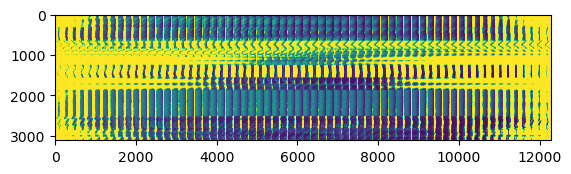

In [107]:
plt.imshow(data)

# spliting data to train, validtion and test 

In [108]:
# Step 1: Split data into training (60%) and remaining (40% for validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, random_state=0)

# Step 2: Split the remaining 40% into validation (20%) and test (20%)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

# Resulting sets
print(f"Training set: {len(x_train)} samples")
print(f"Validation set: {len(x_val)} samples")
print(f"Test set: {len(x_test)} samples")


Training set: 1867 samples
Validation set: 623 samples
Test set: 623 samples


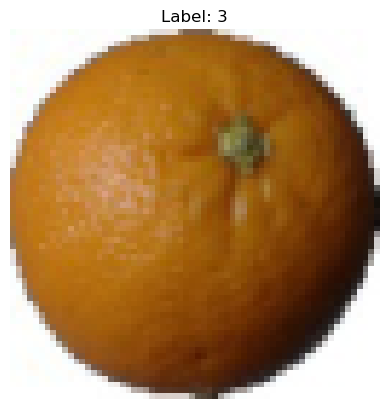

In [109]:
index = 100
img = x_train[index]

# Reshape if necessary
if img.ndim == 1:  # Flattened image
    img = img.reshape((64, 64, 3))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the image
plt.imshow(img)
plt.title(f"Label: {y_train[index]}")
plt.axis("off")
plt.show()

# Train a KNN classifier

In [110]:
knn =  KNeighborsClassifier(n_neighbors=3, metric = 'minkowski', p = 2)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# Calculate training and validation accuracy

In [111]:
# if the gap between train and val is large -> model might be overfitting
train_accuracy = knn.score(x_train, y_train)
val_accuracy = knn.score(x_val, y_val)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")

Training Accuracy: 1.00
Validation Accuracy: 1.00


# Make predictions on the test set

In [112]:
y_pred = knn.predict(x_test)

# Confusion matrix

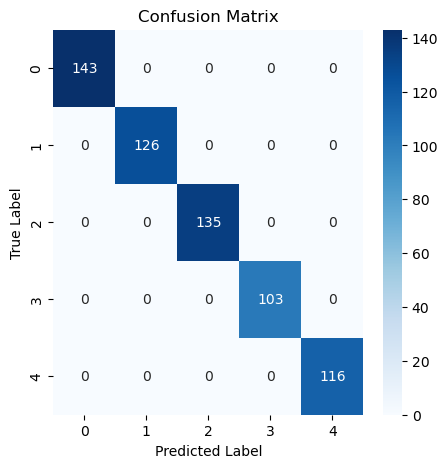

In [113]:
cm = confusion_matrix(y_test, y_pred)
# print(cm) #143 instances of the first class were correctly predicted as the first class.
# Off-diagonal values (all 0s) represent misclassifications

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

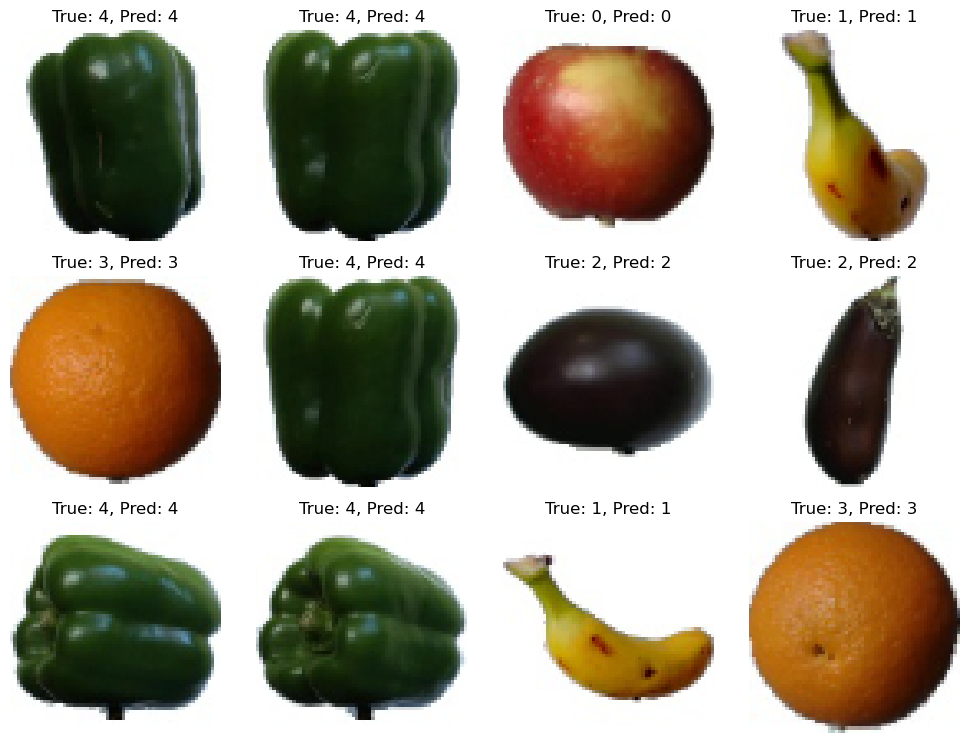

In [114]:
plt.figure(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 4, i + 1)  #nRows, nColumns, index of the image in the graph
    pred_img = x_test[i].reshape((64, 64, 3))
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    plt.imshow(pred_img)

    plt.title(f"True: {y_test[i]}, Pred: {y_pred[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Accuracy

In [115]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


# Precision and Recall

In [117]:
precision = precision_score(y_test, y_pred, average='weighted') #Precision is crucial when false positives are costly
#  calculates the metric for each class and then takes a weighted sum of these metrics
recall = recall_score(y_test, y_pred, average='weighted')       #Recall is crucial when false negatives are costly
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

Precision: 1.00, Recall: 1.00


# ROC and AUC graph

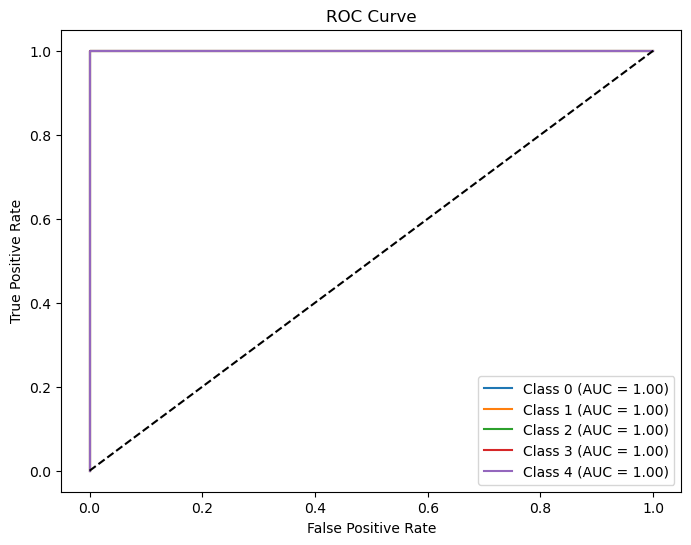

In [118]:
from sklearn.preprocessing import label_binarize

# converts multi-class labels into a binary format 1=> [0, 1, 0, 0, 0] 
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4]) 

# calculate the probability, not just predicted classes
y_prob = knn.predict_proba(x_test)

# falsepositive rate(FPR), true positive rate (TPR), and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

# Calculate FPR, TPR, and AUC for each class
for i in range(y_test_bin.shape[1]):  # iterate 5 times , one for each class
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  
    roc_auc[i] = auc(fpr[i], tpr[i])  # compute AUC

# Plot ROC curves for all classes
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]): 
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')


plt.show()


# Loss function

In [119]:
from sklearn.metrics import log_loss

loss = log_loss(y_test, y_prob)  
print(f"Loss: {loss}")


Loss: 2.2204460492503136e-16
